In [171]:
import os
import re
import opendatasets as od
from itertools import product
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

Data Extraction

In [172]:
data = 'https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data'
od.download(data)
file_paths = os.listdir('./competitive-data-science-predict-future-sales')
df_s = list(map(lambda path: pd.read_csv(f'./competitive-data-science-predict-future-sales/{path}'), file_paths))

Skipping, found downloaded files in ".\competitive-data-science-predict-future-sales" (use force=True to force download)


In [173]:
for df in df_s:
    print(df.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00

Validity: Outliers detection

In [174]:
df_s[2].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Outliers in item_price

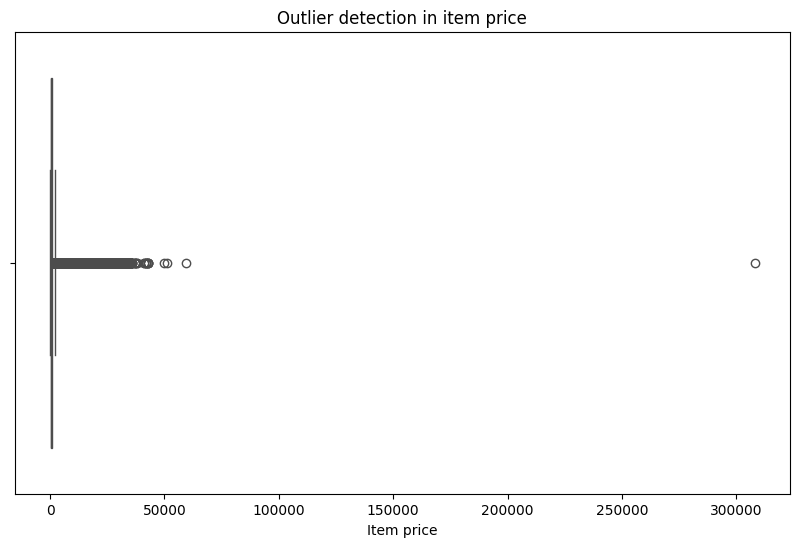

In [175]:
plt.figure(figsize = (10,6))

sns.boxplot(x = df_s[2]['item_price'], color='blue')

plt.xlabel('Item price')
plt.title('Outlier detection in item price')

plt.show()

In [176]:
df_s[2].loc[df_s[2].item_price > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [177]:
df_s[2].loc[df_s[2].item_id == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [178]:
df_s[0].loc[df_s[0].item_id == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [179]:
df_s[1].loc[df_s[1].item_category_id == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


In [180]:
df_s[5].loc[df_s[5].item_id == 6066]

,ID,shop_id,item_id


We do not have this outlier in train set, and there is only one example of this outlier in train set - we could painless drop it

In [181]:
df_s[2] = df_s[2].loc[df_s[2].item_id != 6066]

Outliers in item_cnt_day

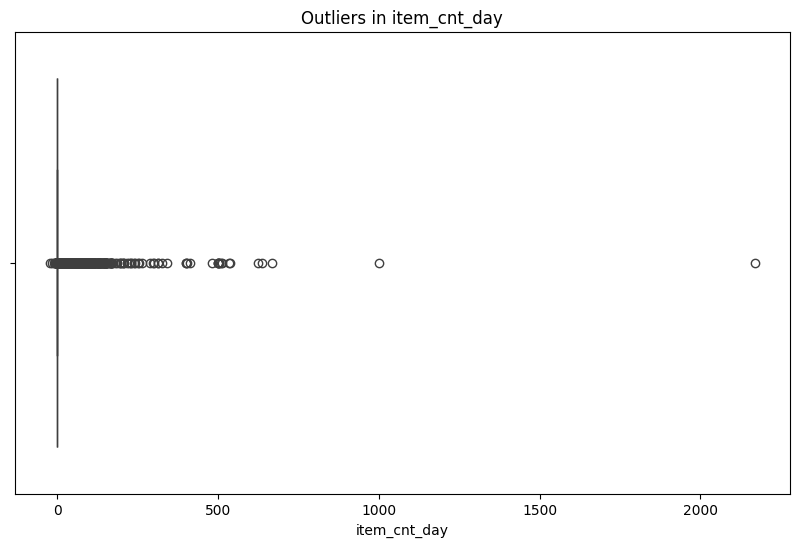

In [182]:
plt.figure(figsize = (10,6))

sns.boxplot(x = df_s[2].item_cnt_day)

plt.xlabel('item_cnt_day')
plt.title('Outliers in item_cnt_day')

plt.show()

In [183]:
df_s[2].loc[df_s[2].item_cnt_day >= 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


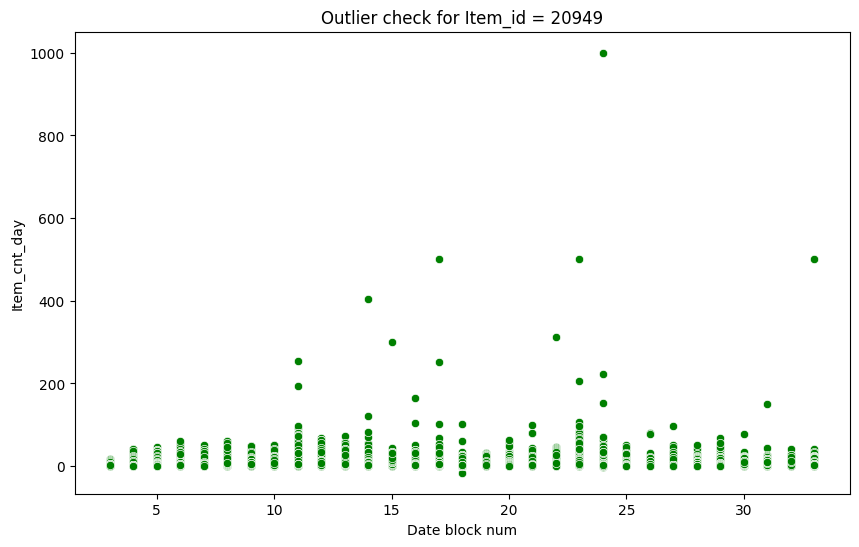

In [184]:
plt.figure(figsize = (10,6))

data = df_s[2].loc[df_s[2].item_id == 20949].reset_index(drop = True)



sns.scatterplot(data = data, x = 'date_block_num', y = 'item_cnt_day', color = 'green')

plt.ylabel('Item_cnt_day')
plt.xlabel('Date block num')
plt.title('Outlier check for Item_id = 20949')

plt.show()

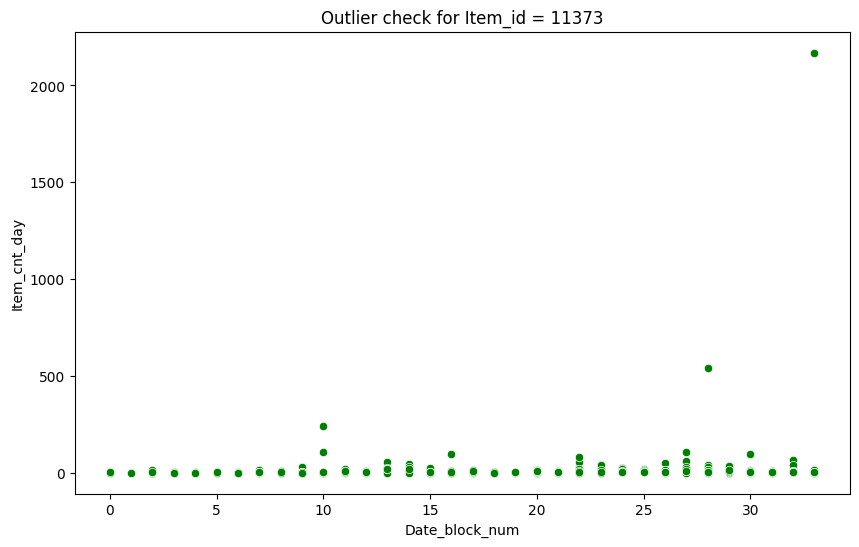

In [185]:
plt.figure(figsize = (10,6))

data = df_s[2].loc[df_s[2].item_id == 11373].reset_index(drop = True)



sns.scatterplot(data = data, x = 'date_block_num', y = 'item_cnt_day', color = 'green')

plt.ylabel('Item_cnt_day')
plt.xlabel('Date_block_num')
plt.title('Outlier check for Item_id = 11373')

plt.show()

We do not have tendencies that will approve preservation of this outliers - we can drop them

In [186]:
df_s[2] = df_s[2].loc[df_s[2].item_cnt_day < 1000]

Consistency: shop_name correction

In [187]:
pattern1 = "^!"
pattern2 = ""
for name in df_s[4]['shop_name'].unique():
    df_s[4].replace({'shop_name': {name: re.sub(pattern1, pattern2, name)}}, inplace = True)

In [188]:
df_s[4]['shop_name'].unique()

array(['Якутск Орджоникидзе, 56 фран', 'Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва ТЦ 

Completeness and Uniqueness check: NAN values and duplicates

In [189]:
for i in range(len(df_s)):
    if df_s[i].isna().values.any():
        print(df_s[i].loc[df_s[i].isna().any(axis=1)])
        print(f'Percentage of missing values: {(df_sales_train.isna().any().sum()/len(df_s[i])):.4%}')
    if df_s[i].duplicated(keep = False).values.any():
        print(df_s[i][df_s[i].duplicated()])
        print(f'\nPercentage of duplicates in df_s[{i}]: {(df_s[i].duplicated().sum()/len(df_s[i])):.4%}')

               date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  

Percentage of duplicates in df_s[2]: 0.0002%


In [190]:
df_items = df_s[0]
df_item_categories = df_s[1]
df_sales_train = df_s[2]
df_sample_submission = df_s[3]
df_shops = df_s[4]
df_test = df_s[5]

Itegrity data by int_snt_month

In [191]:
df_sales_per_month = df_sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg({'item_cnt_day':'sum'})
df_sales_per_month = df_sales_per_month.rename({"item_cnt_day":"item_cnt_month"}, axis=1)
df_sales_per_month.reset_index(inplace = True)

Uniqueness: Check similar named shops

In [192]:
for id in df_sales_per_month['shop_id'].unique():
    if df_sales_per_month[df_sales_per_month['shop_id'] == id].reset_index(drop = True)['date_block_num'].nunique() != 34:
        print(df_shops.loc[df_shops.shop_id == id, 'shop_name'].min())

Якутск Орджоникидзе, 56 фран
Якутск ТЦ "Центральный" фран
Воронеж ТРЦ Сити-Парк "Град"
Жуковский ул. Чкалова 39м?
Казань ТЦ "Бехетле"
Москва ТК "Буденовский" (пав.А2)
Москва ТЦ "МЕГА Белая Дача II"
Москва ТЦ "Новый век" (Новокосино)
Москва ТЦ "Перловский"
Москва ТЦ "Серебряный Дом"
СПб ТК "Сенная"
Тюмень ТЦ "Зеленый Берег"
Химки ТЦ "Мега"
Вологда ТРЦ "Мармелад"
Якутск Орджоникидзе, 56
Якутск ТЦ "Центральный"
Цифровой склад 1С-Онлайн
Красноярск ТЦ "Взлетка Плаза"
Выездная Торговля
Тюмень ТРЦ "Кристалл"
РостовНаДону ТРК "Мегацентр Горизонт"
РостовНаДону ТРК "Мегацентр Горизонт" Островной
Томск ТРЦ "Изумрудный Город"
Н.Новгород ТРЦ "РИО"
Мытищи ТРК "XL-3"
Москва "Распродажа"
Жуковский ул. Чкалова 39м²
Новосибирск ТРЦ "Галерея Новосибирск"


In [193]:
def shop_name_check(shop_name_1, shop_name_2):
    shop_id1 = df_shops.loc[df_shops.shop_name == shop_name_1, 'shop_id'].min()
    c1 = df_sales_per_month[df_sales_per_month['shop_id'] == shop_id1].reset_index(drop = True)
    c1 = pd.DataFrame(c1.groupby('date_block_num').agg({'item_cnt_month': 'mean'}))

    shop_id2 = df_shops.loc[df_shops.shop_name == shop_name_2, 'shop_id'].min()
    c2 = df_sales_per_month[df_sales_per_month['shop_id'] == shop_id2].reset_index(drop = True)
    c2 = pd.DataFrame(c2.groupby('date_block_num').agg({'item_cnt_month': 'mean'}))
    
    plt.figure(figsize = (10,6))

    plt.bar(c1.index, c1['item_cnt_month'], color = 'g', label = shop_name_1, alpha = 0.8)
    plt.bar(c2.index, c2['item_cnt_month'], color = 'b', label = shop_name_2, alpha = 0.7)

    plt.xticks(range(0,34));
    plt.legend()
    plt.xlabel('Date_block_num')
    plt.ylabel('item_cnt_month')
    plt.title('Shops comparison')

    plt.show()


pair 1.Якутск Орджоникидзе, 56 фран and Якутск Орджоникидзе, 56

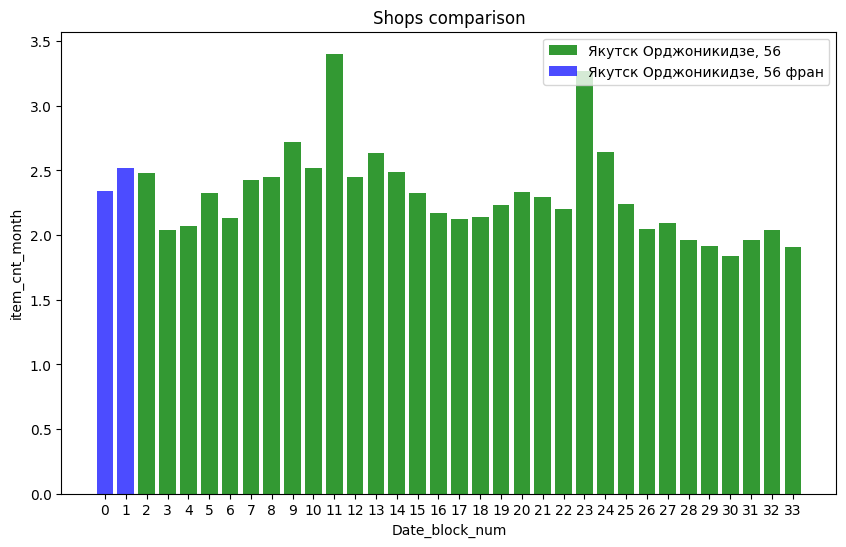

In [194]:
shop_name_check('Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Combining them - we'll get full range of data

In [195]:
def shop_corr(shop_name_1, shop_name_2):
    shop_id1 = df_shops.loc[df_shops.shop_name == shop_name_1, 'shop_id'].min()
    shop_id2 = df_shops.loc[df_shops.shop_name == shop_name_2, 'shop_id'].min()
    df_sales_per_month.replace({'shop_id': {shop_id2: shop_id1}}, inplace = True)
    df_test.replace({'shop_id': {shop_id2: shop_id1}}, inplace = True)

In [196]:
shop_corr('Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Якутск ТЦ "Центральный" фран, Якутск ТЦ "Центральный"

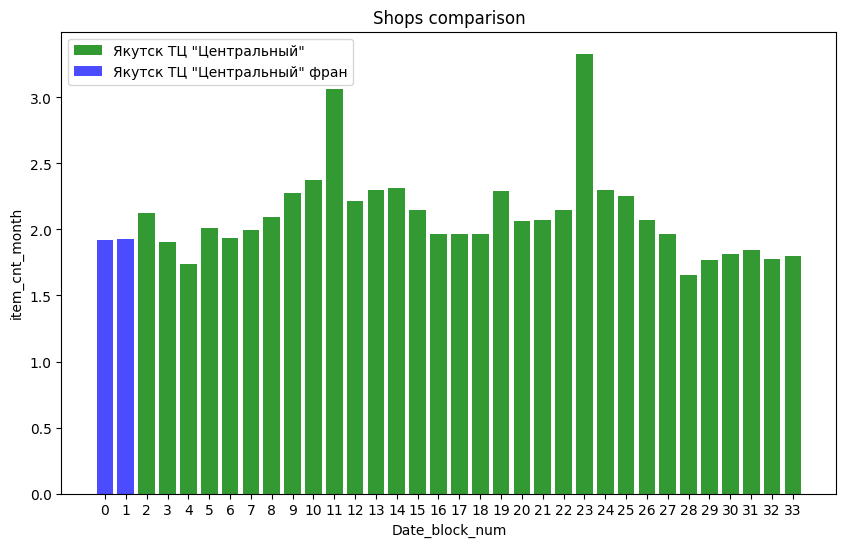

In [197]:
shop_name_check('Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

In [198]:
shop_corr('Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

Жуковский ул. Чкалова 39м?, Жуковский ул. Чкалова 39м²

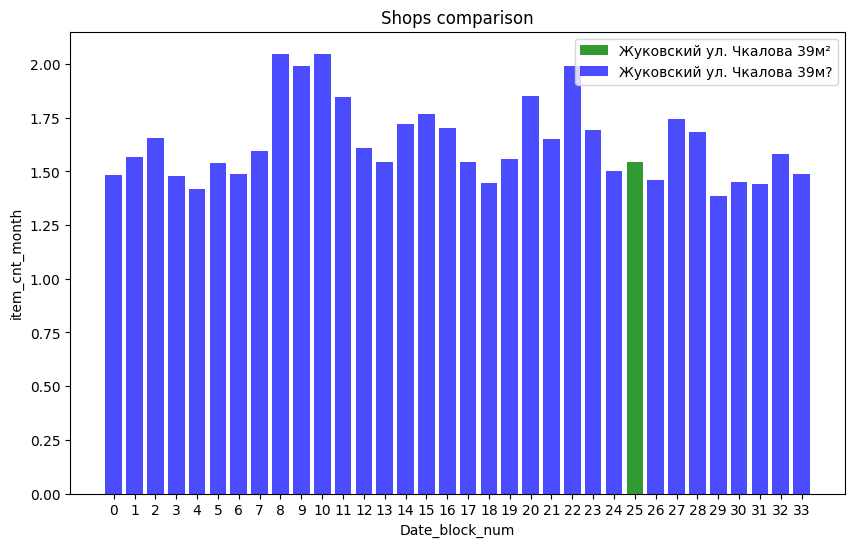

In [199]:
shop_name_check('Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

In [200]:
shop_corr('Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

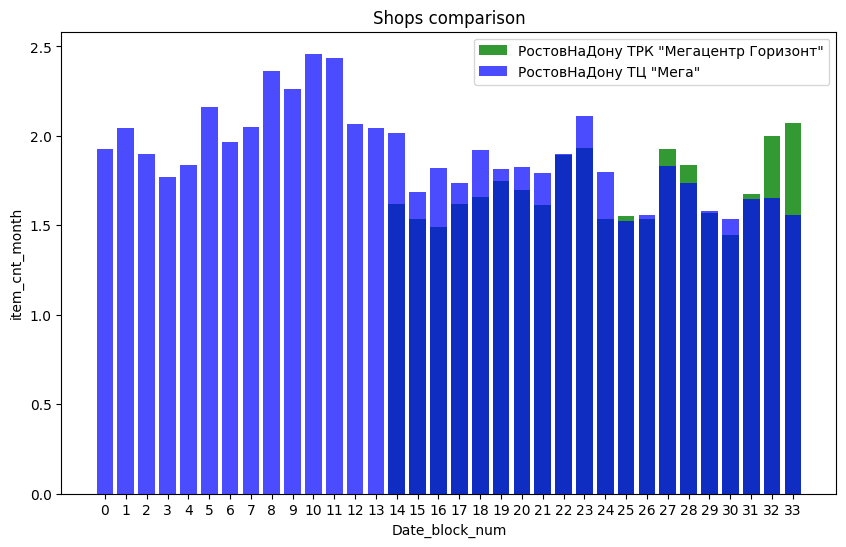

In [201]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТЦ "Мега"'
shop_name_check(shop_name_1, shop_name_2)


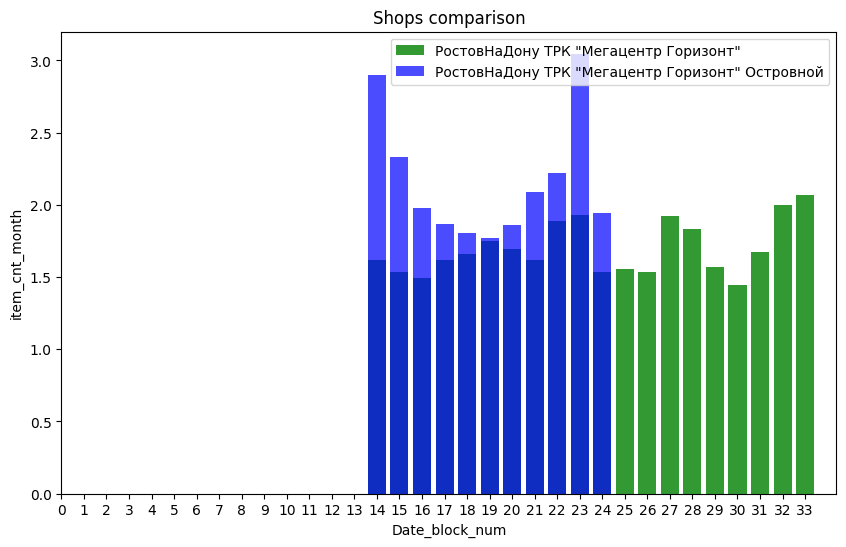

In [202]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТРК "Мегацентр Горизонт" Островной'
shop_name_check(shop_name_1, shop_name_2)


So, as we do not get the full group - we will not combine them

Completeness: counting data that are not present training set that we need to predict

In [203]:
count = 0
for id in df_test.item_id.unique():
    if len(df_sales_per_month[df_sales_per_month.item_id == id]) == 0:
        count += 1
print(f'The total amount of Data that not presenting in train set is {count}')

The total amount of Data that not presenting in train set is 363


counting data that have uncomplete time series range

In [204]:
Count = 0
for id in df_sales_per_month.item_id.unique():
    if df_sales_per_month[df_sales_per_month.shop_id == id].date_block_num.unique != 34:
        count += 1
print(f'The total amount of missing times series data in train set is {count}')

The total amount of missing times series data in train set is 22169


Completeness: Get the full data for full time series range and fill NAN with 0

In [205]:
df_sales_per_month.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,57,32,6.0
1,0,57,33,3.0
2,0,57,35,1.0
3,0,57,43,1.0
4,0,57,51,2.0


In [206]:
total_data = []

for i in range(34):
    sales = df_sales_per_month[df_sales_per_month.date_block_num==i]
    total_data.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique()))))

columns = ['date_block_num','shop_id','item_id']
total_data = pd.DataFrame(np.vstack(total_data), columns=columns)
total_data.sort_values(by = columns, inplace = True)

In [207]:
total_data = total_data.merge(df_sales_per_month, on = columns, how = 'left')
total_data.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


In [208]:
total_data.isna().sum()

date_block_num          0
shop_id                 0
item_id                 0
item_cnt_month    9304682
dtype: int64

In [209]:
total_data['item_cnt_month'] = total_data['item_cnt_month'].fillna(0)

Completeness and Adding data from test set that not in our train set

In [210]:
df_test['date_block_num'] = 34
total_data = pd.concat([total_data, df_test], ignore_index=True, sort=False, keys=columns)
total_data.isna().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_29804\4067152389.py:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  total_data = pd.concat([total_data, df_test], ignore_index=True, sort=False, keys=columns)


date_block_num           0
shop_id                  0
item_id                  0
item_cnt_month      214200
ID                10913804
dtype: int64

In [211]:
total_data.drop('ID', axis = 1, inplace = True)
total_data = total_data.fillna(0)

Integrity of data

In [212]:
merge_params = [[df_items, 'item_id'], [df_item_categories, 'item_category_id'], [df_shops, 'shop_id']]
for params in merge_params:
    total_data = pd.merge(total_data, params[0], on = params[1], how = 'left')
total_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_category_name,shop_name
0,0,2,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,"Адыгея ТЦ ""Мега"""
1,0,2,27,1.0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега"""
2,0,2,28,0.0,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,"Адыгея ТЦ ""Мега"""
3,0,2,29,0.0,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,"Адыгея ТЦ ""Мега"""
4,0,2,32,0.0,1+1,40,Кино - DVD,"Адыгея ТЦ ""Мега"""


ETL - load

In [214]:
total_data.to_csv('total_data.csv')

EDA

In [217]:
total_data = pd.read_csv('total_data.csv', index_col = 0)

In [218]:
total_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_category_name,shop_name
0,0,2,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,"Адыгея ТЦ ""Мега"""
1,0,2,27,1.0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега"""
2,0,2,28,0.0,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,"Адыгея ТЦ ""Мега"""
3,0,2,29,0.0,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,"Адыгея ТЦ ""Мега"""
4,0,2,32,0.0,1+1,40,Кино - DVD,"Адыгея ТЦ ""Мега"""


As we put in our total data columns also for date_block_num == 34 that we need to predict (we fill it with 0), for analysis of train data we take data for date_block_num <34

In [371]:
total_data.describe()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
count,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07
mean,1.533960e+01,3.138372e+01,1.130371e+04,3.275552e-01,4.494398e+01
std,9.760412e+00,1.730666e+01,6.210934e+03,3.302990e+00,1.514000e+01
min,0.000000e+00,2.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.947000e+03,0.000000e+00,3.700000e+01
50%,1.500000e+01,3.100000e+01,1.138800e+04,0.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.659200e+04,0.000000e+00,5.500000e+01
max,3.400000e+01,5.900000e+01,2.216900e+04,1.644000e+03,8.300000e+01


How our target(item_cnt_month) perform during all date range

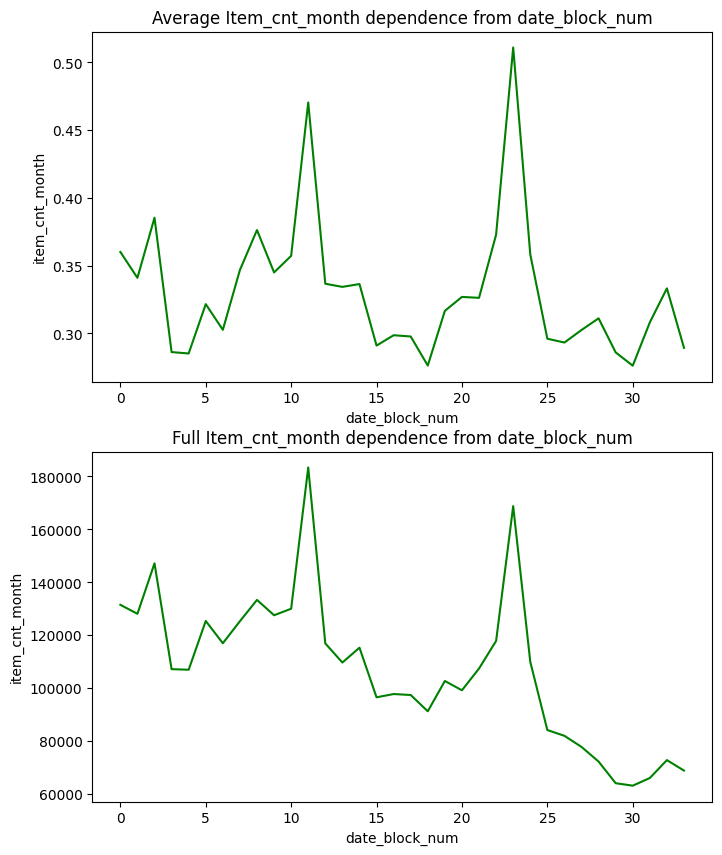

In [370]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

sns.lineplot(data = total_data.loc[total_data['date_block_num'] < 34].groupby('date_block_num').agg({'item_cnt_month': 'mean'}), x = 'date_block_num', y = 'item_cnt_month', c = 'g', ax = ax[0]).set_title('Average Item_cnt_month dependence from date_block_num')

sns.lineplot(data = total_data.loc[total_data['date_block_num'] < 34].groupby('date_block_num').agg({'item_cnt_month': 'sum'}), x = 'date_block_num', y = 'item_cnt_month', c = 'g', ax = ax[1]).set_title('Full Item_cnt_month dependence from date_block_num')

plt.show()

As we can see some peaks - it will be reasonable to create features to see dependencies during smaller ranges of times (during half a year and during 1 year)

Shop_id - target dependence

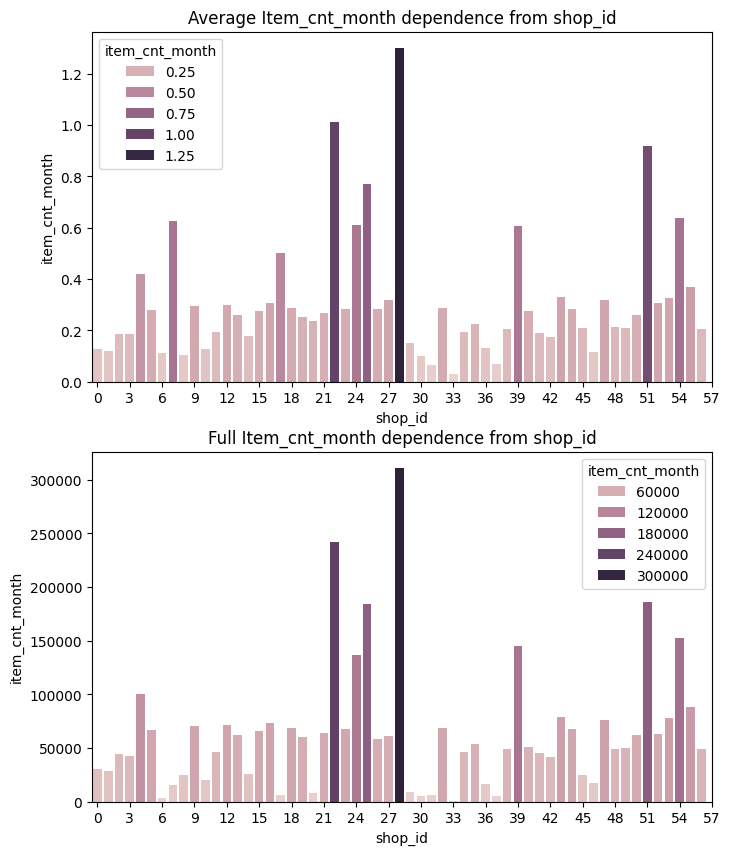

In [367]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

length = len(total_data.groupby('shop_id').agg({'item_cnt_month': 'mean'})) + 1

sns.barplot(data = total_data.groupby('shop_id').agg({'item_cnt_month': 'mean'}), x = 'shop_id', y = 'item_cnt_month', ax = ax[0], hue = 'item_cnt_month').set_title('Average Item_cnt_month dependence from shop_id')

sns.barplot(data = total_data.groupby('shop_id').agg({'item_cnt_month': 'sum'}), x = 'shop_id', y = 'item_cnt_month', ax = ax[1], hue = 'item_cnt_month').set_title('Full Item_cnt_month dependence from shop_id')

plt.setp(ax, xticks=np.arange(0, length, 3), xticklabels=np.arange(0, length, 3),)
plt.show()

Item-category_id dependence

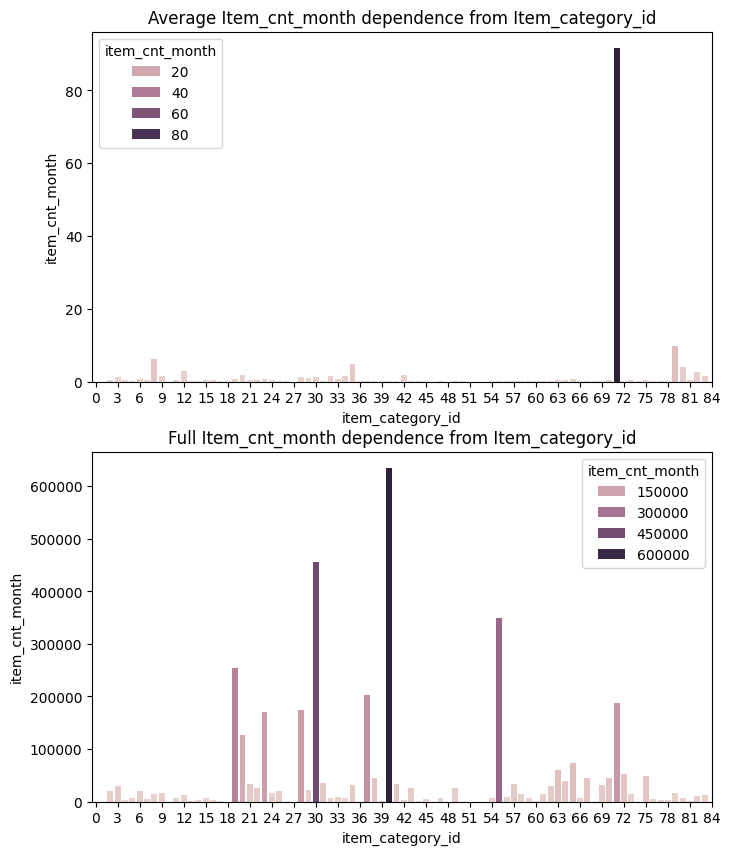

In [368]:
figure, ax = plt.subplots(2, 1, figsize = (8,10))

length = len(total_data.groupby('item_category_id').agg({'item_cnt_month': 'mean'})) + 1

sns.barplot(data = total_data.groupby('item_category_id').agg({'item_cnt_month': 'mean'}), x = 'item_category_id', y = 'item_cnt_month', ax = ax[0], hue = 'item_cnt_month').set_title('Average Item_cnt_month dependence from Item_category_id')

sns.barplot(data = total_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'}), x = 'item_category_id', y = 'item_cnt_month', ax = ax[1], hue = 'item_cnt_month').set_title('Full Item_cnt_month dependence from Item_category_id')

plt.setp(ax, xticks=np.arange(0, length, 3), xticklabels=np.arange(0, length, 3),)
plt.show()

In [372]:
total_data.loc[total_data.item_category_id == 71]['item_category_name'].unique()

array(['Подарки - Сумки, Альбомы, Коврики д/мыши'], dtype=object)

In [373]:
total_data.loc[total_data.item_category_id == 71]['item_name'].unique()

array(['Крафт пакет "Интересные подарки"-оранжевый',
       'Чехол URBAN TOOL slyDog national RU',
       'Чехол URBAN TOOL slyDog national TR',
       'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм',
       'Tucano. Коврик для мыши "Ромашка", Delikatessen, MPDEL-153',
       'Крафт пакет "Интересные подарки"'], dtype=object)

For this category such high sales rate is not strange, because the sales of bags going along with almost of sales of other items in the same time

In [374]:
total_data.loc[total_data.item_category_id == 40]['item_name'].nunique()

5035

Also, the category include a lot of unique items - it will be reasonable to divide this main category on some small branches to get more accurate information about sold item